In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
import numpy as np
import matplotlib.pyplot as plt

import json

import keras_tuner as kt
import tensorflow as tf

from geexhp import datavis as dvis
dvis.configure_matplotlib()

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [2]:
with open('normalization_stats.json') as f:
    stats = json.load(f)

input_stats = {
    'UV': (stats['inputs']['UV']['mean'], stats['inputs']['UV']['std']),
    'Vis': (stats['inputs']['Vis']['mean'], stats['inputs']['Vis']['std']),
    'NIR': (stats['inputs']['NIR']['mean'], stats['inputs']['NIR']['std'])
}

output_stats = {
    key: (stats['outputs'][key]['mean'], stats['outputs'][key]['std'])
    for key in stats['outputs']
}

In [3]:
def parse_example(example_proto, input_stats, output_stats):
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
        'log_CH4': tf.io.FixedLenFeature([], tf.float32),
        'log_CO': tf.io.FixedLenFeature([], tf.float32),
        'log_CO2': tf.io.FixedLenFeature([], tf.float32),
        'log_H2O': tf.io.FixedLenFeature([], tf.float32),
        'log_N2': tf.io.FixedLenFeature([], tf.float32),
        'log_N2O': tf.io.FixedLenFeature([], tf.float32),
        'log_O2': tf.io.FixedLenFeature([], tf.float32),
        'log_O3': tf.io.FixedLenFeature([], tf.float32)
    }

    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # ----------------------
    # Input Normalization
    # ----------------------
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        # Get raw spectrum
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)
        
        # Normalize using dataset statistics
        mean = input_stats[region][0]
        std = input_stats[region][1]
        normalized = (spectrum - mean) / std
        
        # Reshape to appropriate dimensions
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])
            
        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    # ----------------------
    # Output Processing
    # ----------------------
    processed_outputs = {}
    
    radius = parsed['OBJECT-RADIUS-REL-EARTH']
    processed_outputs['OBJECT-RADIUS-REL-EARTH'] = (radius - output_stats['OBJECT-RADIUS-REL-EARTH'][0]) / output_stats['OBJECT-RADIUS-REL-EARTH'][1]
    
    gravity = parsed['OBJECT-GRAVITY']
    processed_outputs['OBJECT-GRAVITY'] = (gravity - output_stats['OBJECT-GRAVITY'][0]) / output_stats['OBJECT-GRAVITY'][1]
    
    temperature = parsed['ATMOSPHERE-TEMPERATURE']
    processed_outputs['ATMOSPHERE-TEMPERATURE'] = (temperature - output_stats['ATMOSPHERE-TEMPERATURE'][0]) / output_stats['ATMOSPHERE-TEMPERATURE'][1]
    
    pressure = parsed['ATMOSPHERE-PRESSURE']
    processed_outputs['ATMOSPHERE-PRESSURE'] = (pressure - output_stats['ATMOSPHERE-PRESSURE'][0]) / output_stats['ATMOSPHERE-PRESSURE'][1]
    
    for chem in ['log_C2H6', 'log_CH4', 'log_CO', 'log_CO2', 'log_H2O', 'log_N2', 'log_N2O', 'log_O2', 'log_O3']:
        chem_value = parsed[chem]
        processed_outputs[f'{chem}'] = (chem_value - output_stats[f'{chem}'][0]) /  output_stats[f'{chem}'][1]

    # processed_outputs['Earth_type'] = parsed['Earth_type']
    # processed_outputs["NOISE_B-NIR"] = parsed["NOISE_B-NIR"]

    return normalized_inputs, processed_outputs

In [4]:
def read_tfrecord(file_path, input_stats, output_stats, 
                    batch_size=1000, shuffle_buffer=True, repeat=False):
    
    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality())

    # Parse the dataset after shuffling
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Repeat the dataset for multiple epochs
    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    # Batch after shuffling and parsing
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

In [5]:
train_ds = read_tfrecord("../data/train.tfrecord", input_stats, output_stats)
val_ds = read_tfrecord("../data/val.tfrecord", input_stats, output_stats)
test_ds = read_tfrecord("../data/test.tfrecord", input_stats, output_stats)

In [6]:
batch = next(iter(train_ds.take(1)))

print("\n## Input Shapes:")
for k,v in batch[0].items():
    print(f"> {k}: {v.shape}") 

print("\n## Output Ranges (standardized):")
for k,v in batch[1].items():
    if k != 'Earth_type':
        print(f"> {k}: {tf.reduce_mean(v):.3f} ± {tf.math.reduce_std(v):.6f}")


## Input Shapes:
> NOISY_ALBEDO_B-UV: (1000, 8, 1)
> NOISY_ALBEDO_B-Vis: (1000, 94, 1)
> NOISY_ALBEDO_B-NIR: (1000, 49, 1)

## Output Ranges (standardized):
> OBJECT-RADIUS-REL-EARTH: -0.009 ± 0.980294
> OBJECT-GRAVITY: -0.008 ± 0.980921
> ATMOSPHERE-TEMPERATURE: 0.027 ± 1.001278
> ATMOSPHERE-PRESSURE: -0.017 ± 0.980249
> log_C2H6: -0.006 ± 1.008588
> log_CH4: -0.051 ± 1.023011
> log_CO: -0.025 ± 0.970603
> log_CO2: -0.031 ± 1.011120
> log_H2O: -0.050 ± 1.045590
> log_N2: 0.016 ± 0.974665
> log_N2O: -0.005 ± 0.999710
> log_O2: 0.034 ± 0.961077
> log_O3: 0.002 ± 0.997734


In [7]:
def plot_spectrum(ds, sample_number):
    for batch in ds.take(1):
        pass

    x1 = batch[0]['NOISY_ALBEDO_B-UV'][sample_number]
    x2 = batch[0]['NOISY_ALBEDO_B-Vis'][sample_number]
    x3 = batch[0]['NOISY_ALBEDO_B-NIR'][sample_number]

    UV = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
    VIS = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
    NIR = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

    plt.plot(UV, x1, label='UV')
    plt.plot(VIS, x2, label='Vis')
    plt.plot(NIR, x3, label='NIR')
    plt.legend()
    plt.show()

    for output in batch[1].keys():
        print(f'> {output}: \t {batch[1][output][sample_number]}')

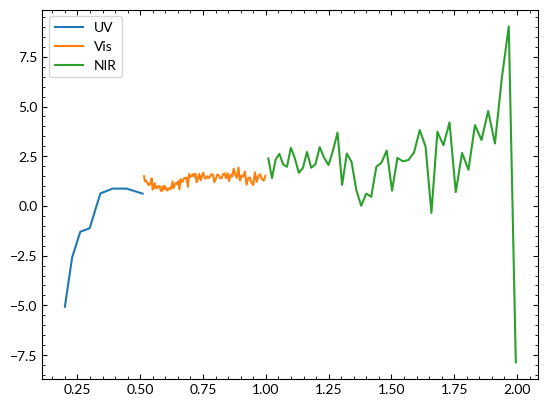

> OBJECT-RADIUS-REL-EARTH: 	 -1.3039770126342773
> OBJECT-GRAVITY: 	 -1.291933536529541
> ATMOSPHERE-TEMPERATURE: 	 -0.6760183572769165
> ATMOSPHERE-PRESSURE: 	 -1.2069456577301025
> log_C2H6: 	 0.6936268210411072
> log_CH4: 	 -1.4011609554290771
> log_CO: 	 -0.3211584985256195
> log_CO2: 	 -0.2772165536880493
> log_H2O: 	 -0.7810219526290894
> log_N2: 	 0.4404151439666748
> log_N2O: 	 -0.22167879343032837
> log_O2: 	 -0.26425039768218994
> log_O3: 	 -0.29552820324897766


In [8]:
plot_spectrum(train_ds, 0)

In [9]:
TRAIN_SAMPLES = 779887
VAL_SAMPLES = 66676
BATCH_SIZE = 1000

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

In [10]:
def conv_1D_block(input_tensor, num_filters, kernel_size=3, strides=1,
                    kernel_initializer='glorot_uniform', activation='swish'):
    input_shape = input_tensor.shape[1]  # Get input sequence length
    kernel_size = min(kernel_size, input_shape)  # Ensure kernel <= input size

    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                kernel_initializer=kernel_initializer,
                                activation=activation, padding="same")(input_tensor)  
    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                kernel_initializer=kernel_initializer,
                                activation=activation, padding="same")(z)

    if z.shape[1] > 2:  # Prevent excessive pooling
        z = tf.keras.layers.MaxPooling1D(pool_size=2)(z)
    
    return z

In [11]:
def build_model_3(hp):
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

    # Hyperparameters
    dense_l2 = hp.Choice('dense_l2', [1e-4, 1e-3, 1e-2])
    concat_filters = hp.Int('concat_filters', min_value=4, max_value=64, step=8) 
    uv_filters = hp.Choice('uv_filters', [4, 8])
    vis_filters = hp.Int('vis_filters', min_value=8, max_value=64, step=8)
    nir_filters = hp.Int('nir_filters', min_value=8, max_value=64, step=8)
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    uv_kernel = hp.Choice('uv_kernel', [2, 3])
    dense_units1 = hp.Int('dense_units1', min_value=64, max_value=256, step=32)
    dense_units2 = hp.Int('dense_units2', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    lr = hp.Choice('learning_rate', [1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2])

    # Inputs
    input_uv = tf.keras.layers.Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    # First convolutional branch of the network.
    concat_branch = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])
    concat_branch = conv_1D_block(concat_branch, concat_filters, kernel_size)
    concat_branch = conv_1D_block(concat_branch, max(8, concat_filters//2), kernel_size)
    concat_branch = tf.keras.layers.GlobalAveragePooling1D()(concat_branch)

    # UV convolutional branch.
    UV = conv_1D_block(input_uv, uv_filters, uv_kernel)
    UV = tf.keras.layers.GlobalAveragePooling1D()(UV)

    # Vis convolutional branch.
    VIS = conv_1D_block(input_vis, vis_filters, kernel_size)
    VIS = conv_1D_block(VIS, max(8, vis_filters//2), kernel_size)
    VIS = conv_1D_block(VIS, max(8, vis_filters//4), kernel_size)
    VIS = tf.keras.layers.GlobalAveragePooling1D()(VIS)

    # NIR convolutional branch.
    NIR = conv_1D_block(input_nir, nir_filters, kernel_size)
    NIR = conv_1D_block(NIR, max(8, nir_filters//2), kernel_size)
    NIR = tf.keras.layers.GlobalAveragePooling1D()(NIR)
    
    combined_braches = tf.keras.layers.Concatenate()([concat_branch, UV, VIS, NIR])

    x = tf.keras.layers.Dense(dense_units1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(combined_braches)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units2, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(dense_l2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(units=1, activation='linear', kernel_regularizer=tf.keras.regularizers.l1(1e-5), name=output_name)(x)
        outputs[output_name] = output

    losses = {output_name: 'mae' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="test_5")
    model.compile(optimizer=opt, loss=losses)

    return model

In [12]:
tuner = kt.BayesianOptimization(
    build_model_3,
    objective='val_loss',
    max_trials=10,
    directory='opt',
    project_name='bayesopt'
)

In [13]:
tuner.search(train_ds, epochs=5, validation_data=val_ds)

Trial 10 Complete [00h 16m 32s]
val_loss: 5.331714630126953

Best val_loss So Far: 4.541463375091553
Total elapsed time: 02h 27m 32s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [20]:
print("Best Hyperparameters:")
print(f"- dense_l2: {best_hps.get('dense_l2')}")
print(f"- concat_filters: {best_hps.get('concat_filters')}")
print(f"- uv_filters: {best_hps.get('uv_filters')}")
print(f"- vis_filters: {best_hps.get('vis_filters')}")
print(f"- nir_filters: {best_hps.get('nir_filters')}")
print(f"- kernel_size: {best_hps.get('kernel_size')}")
print(f"- uv_kernel: {best_hps.get('uv_kernel')}")
print(f"- dense_units1: {best_hps.get('dense_units1')}")
print(f"- dense_units2: {best_hps.get('dense_units2')}")
print(f"- dropout_rate: {best_hps.get('dropout_rate')}")
print(f"- learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
- dense_l2: 0.001
- concat_filters: 52
- uv_filters: 4
- vis_filters: 56
- nir_filters: 40
- kernel_size: 5
- uv_kernel: 3
- dense_units1: 96
- dense_units2: 192
- dropout_rate: 0.1
- learning_rate: 0.005


In [15]:
best_model = build_model_3(best_hps)

In [19]:
best_model.summary()

Model: "test_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_B-Vis  │ (None, 94, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 94, 56)    │        336 │ NOISY_ALBEDO_B-V… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-UV   │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-NIR  │ (None, 49, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 94, 56)    │     15,736 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 151, 1)    │          0 │ NOISY_ALBEDO_B-U… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_B-V… │
│                     │                   │            │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 47, 56)    │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 151, 52)   │        312 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 47, 28)    │      7,868 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 49, 40)    │        240 │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 151, 52)   │     13,572 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 47, 28)    │      3,948 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 49, 40)    │      8,040 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 75, 52)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 23, 28)    │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 24, 40)    │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 75, 26)    │      6,786 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 8, 4)      │         16 │ NOISY_ALBEDO_B-U… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 23, 14)    │      1,974 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 24, 20)    │      4,020 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 302,369 (1.15 MB)

 Trainable params: 100,789 (393.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,580 (787.43 KB)

In [16]:
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 296s 364ms/step - ATMOSPHERE-PRESSURE_loss: 0.5820 - ATMOSPHERE-TEMPERATURE_loss: 0.7554 - OBJECT-GRAVITY_loss: 0.5839 - OBJECT-RADIUS-REL-EARTH_loss: 0.5778 - log_C2H6_loss: 0.3128 - log_CH4_loss: 0.4813 - log_CO2_loss: 0.6354 - log_CO_loss: 0.5519 - log_H2O_loss: 0.5956 - log_N2O_loss: 0.3639 - log_N2_loss: 0.4321 - log_O2_loss: 0.5075 - log_O3_loss: 0.3420 - loss: 6.8484 - val_ATMOSPHERE-PRESSURE_loss: 0.3669 - val_ATMOSPHERE-TEMPERATURE_loss: 0.7353 - val_OBJECT-GRAVITY_loss: 0.3626 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.3587 - val_log_C2H6_loss: 0.1469 - val_log_CH4_loss: 0.3039 - val_log_CO2_loss: 0.5355 - val_log_CO_loss: 0.4624 - val_log_H2O_loss: 0.3785 - val_log_N2O_loss: 0.2122 - val_log_N2_loss: 0.3341 - val_log_O2_loss: 0.3009 - val_log_O3_loss: 0.1721 - val_loss: 4.8470
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 286s 359ms/step - ATMOSPHERE-PRESSURE_loss: 0.4030 - ATMOSPHERE-TEMPERATURE_loss: 0.7443 - OBJECT-GRAVITY_loss: 0.3985 - OBJEC

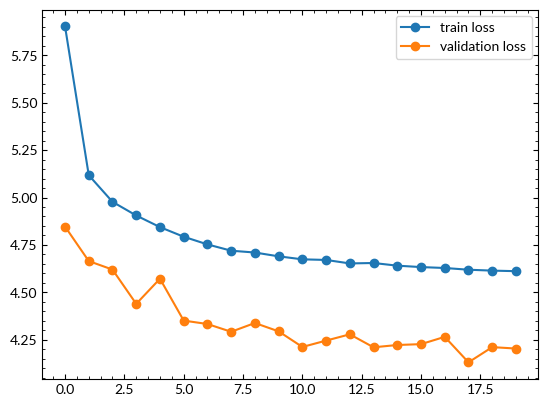

In [17]:
plt.plot(range(20), history.history["loss"], marker="o", label="train loss")
plt.plot(range(20), history.history["val_loss"], marker="o", label="validation loss")
plt.legend();

In [21]:
predictions = best_model.predict(test_ds)

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [22]:
all_true = {key: [] for key in output_stats.keys()}
for batch_in, batch_out in test_ds:
    for key in output_stats:
        all_true[key].append(batch_out[key].numpy())
for key in all_true:
    all_true[key] = np.concatenate(all_true[key], axis=0)

In [ ]:
denorm_pred = {}
denorm_true = {}
for key in output_stats:
    mean_val = output_stats[key][0]
    std_val  = output_stats[key][1]

    y_pred_norm = predictions[key].reshape(-1)
    y_true_norm = all_true[key].reshape(-1)
    
    denorm_pred[key] = y_pred_norm * std_val + mean_val
    denorm_true[key] = y_true_norm * std_val + mean_val

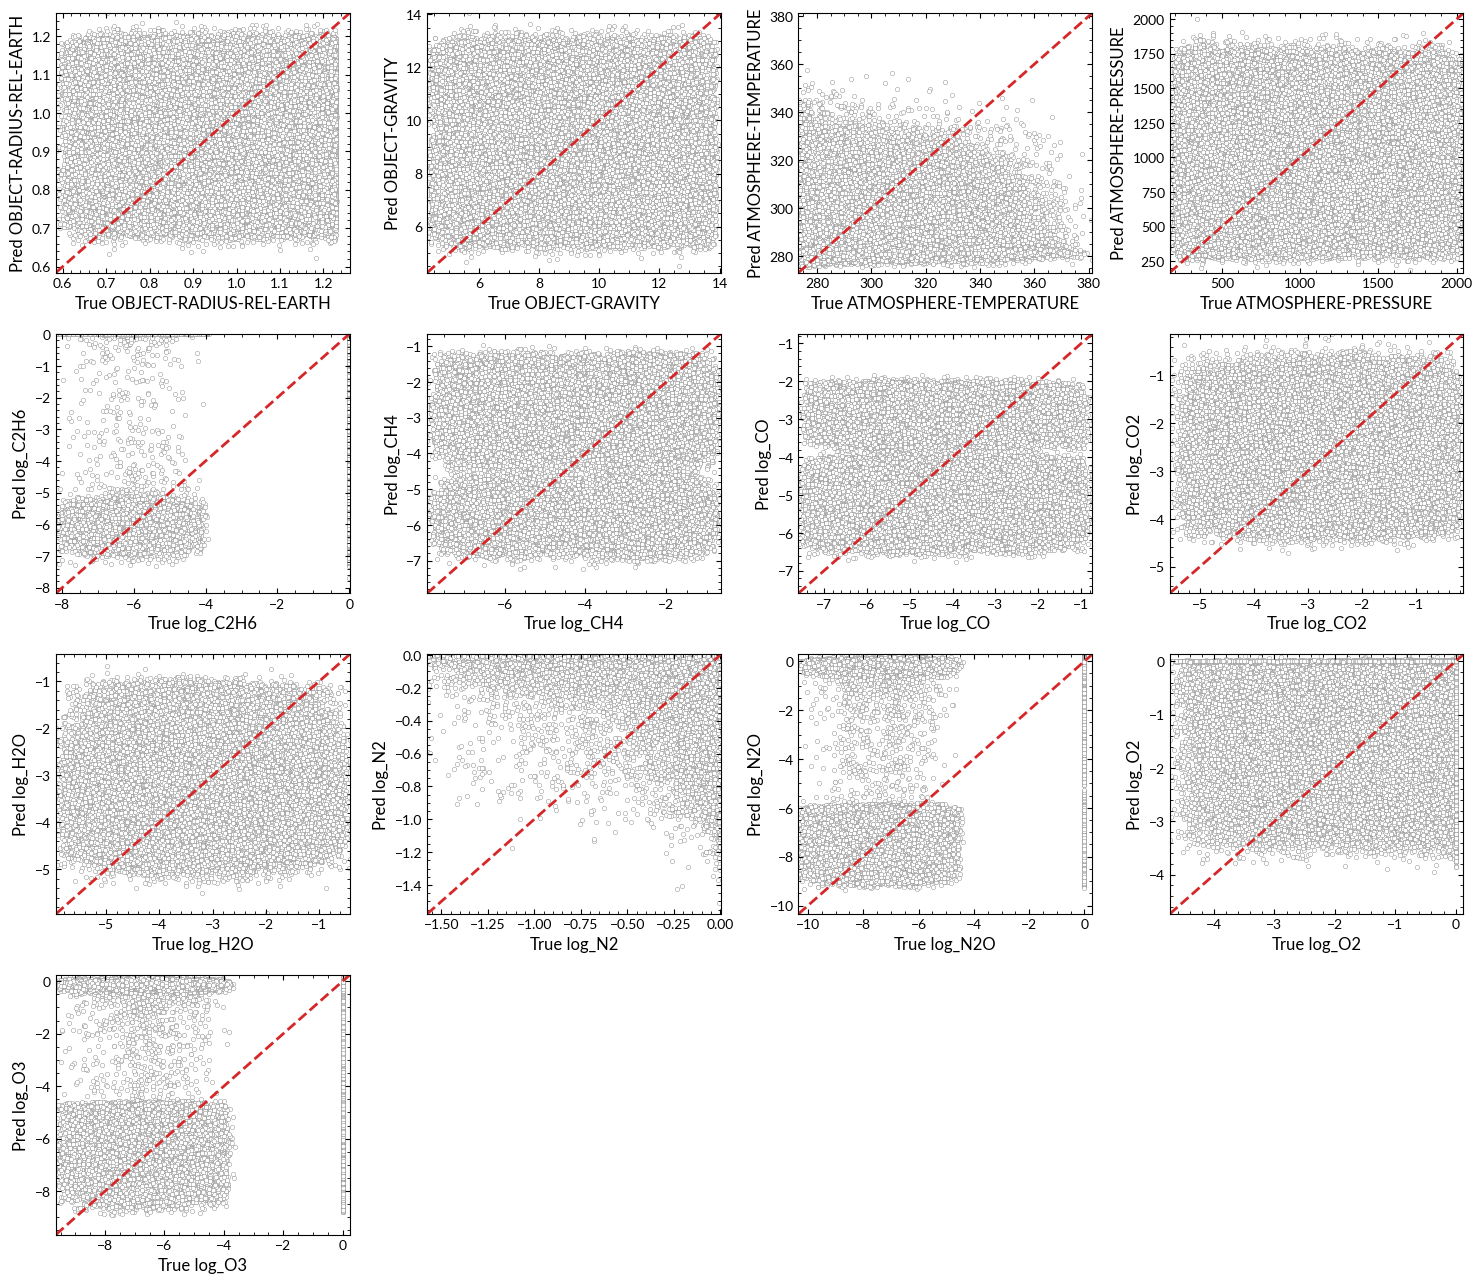

In [52]:
n_keys = len(output_stats.keys())
n_cols = 4  
n_rows = int(np.ceil(n_keys / n_cols)) 

plt.figure(figsize=(15, 13)) 
plt.subplots_adjust(wspace=0.3, hspace=0.4) 

for idx, key in enumerate(output_stats.keys(), 1):
    ax = plt.subplot(n_rows, n_cols, idx)
    
    ax.scatter(denorm_true[key], denorm_pred[key], s=10, edgecolor="gray", color="white", linewidth=0.3)
    
    min_val = min(denorm_true[key].min(), denorm_pred[key].min())
    max_val = max(denorm_true[key].max(), denorm_pred[key].max())
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    ax.set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    
    ax.set_xlabel(f"True {key}")
    ax.set_ylabel(f"Pred {key}")
    
for idx in range(n_keys+1, n_rows*n_cols+1):
    plt.subplot(n_rows, n_cols, idx).axis('off')

plt.tight_layout();